<a href="https://www.kaggle.com/code/hoanganh4511/tsp-using-ga?scriptVersionId=126283871" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# đọc dữ liệu vào tạo ma trận khoảng cách
def getDistance(path, ftype='txt'):
    if ftype == 'txt':
        # đọc dữ liệu
        cities = []
        f = open(path)
        for i in f.readlines():
            node_city_val = i.split()
            cities.append(
                [node_city_val[0], float(node_city_val[1]), float(node_city_val[2])]
            )
    else:
        # Open input file
        infile = open(path, 'r')

        cities = []
        for i, j in enumerate(infile.readlines()):
            node_city_val = j.split()
            if i > 6 and len(node_city_val) == 3 :
                cities.append(
                    [node_city_val[0], float(node_city_val[1]), float(node_city_val[2])]
                )

        # Close input file
        infile.close()
    
    # tạo ma trận khoảng cách
    dis_mat = []
    for cityA in cities:
        dis_vec = []
        for cityB in cities:
            dis = ((cityA[1] - cityB[1])**2 + (cityA[2] - cityB[2])**2)**0.5
            dis_vec.append(dis)
        dis_mat.append(dis_vec)
    
    return cities, dis_mat

In [3]:
# hàm tính tổng khoảng cách <=> fitness()
def totalDistance(individual):
    #cities: là 1 lời giải (cá thể) dưới dạng danh sách các thành phố sẽ đi qua
    # ví dụ n = 5: [[*3,15,10],[*1,5,10],[*2,50,34],[*5,1,20],[*4,23,31]]
    summ = 0
    n = len(individual)
    for i in range(n - 1):
        cityA = int(individual[i]) - 1
        cityB = int(individual[i + 1]) - 1
        summ += dis_mat[cityA][cityB]
    
    # quay lại thành phố đầu tiên
    cityA = int(individual[0]) - 1
    cityB = int(individual[-1]) - 1
    summ += dis_mat[cityA][cityB]
    
    return summ

In [4]:
# khởi tạo quần thể ban đầu 
def initPopulation(cities, size):
    population = []

    for i in range(size):
        invi = list(np.array(cities.copy())[:,0])
        random.shuffle(invi)
        distance = totalDistance(invi)
        population.append([distance, invi])

    return population

In [5]:
# Toán tử lai 1 điểm cắt
#   father1: 2,3,5|1,4    father2: 1,3,5|4,2     điểm cắt: 3
# new_invi1: 1,3,5,2,4  new_invi2: 2,3,5,1,4
def singlePointCrossover(father1, father2, lenCities=51):
    point = random.randint(0, lenCities - 1)
    
    new_invi1 = father2[0:point]
    for invi in father1:
        if invi not in new_invi1:
            new_invi1.append(invi)
            
    new_invi2 = father1[0:point]
    for invi in father2:
        if invi not in new_invi2:
            new_invi2.append(invi)
            
    return new_invi1, new_invi2

# Toán tử lai 2 điểm cắt
#   father1: 6,2|4,3|1,5    father2: 6,1|3,5|4,2     điểm cắt: 2,4
# new_invi1: 6,2,3,5,4,1  new_invi2: 6,1,4,3,5,2
def multiPointCrossover(father1, father2, lenCities=51):
    points = sorted(random.sample(father1, 2))
    point1 = int(points[0]) - 1
    point2 = int(points[1]) - 1
    
    new_invi1 = father2[point1:point2]
    count = 0
    for invi in father1:
        if invi not in new_invi1:
            count += 1
            if count <= point1:
                new_invi1.insert(0, invi)
            else:
                new_invi1.append(invi)
            
            
    new_invi2 = father1[point1:point2]
    count = 0
    for invi in father2:
        if invi not in new_invi2:
            count += 1
            if count <= point1:
                new_invi2.insert(0, invi)
            else:
                new_invi2.append(invi)
                
    return new_invi1, new_invi2

# Toán tử lai vòng
# father1: 12345678
# father2: 85213647
# start=1 => inv1: 1**4**78 => 15243678
# start=2 => inv2: *23*5*** => 82315647
def cycleCrossover(father1, father2, lenCities=51):
    father1 = [int(s) for s in father1]
    father2 = [int(s) for s in father2]
    
    points = sorted(random.sample([i for i in range(lenCities)], 2))
    p1 = 0#p1 = int(points[0])
    p2 = 1#int(points[1])
    
    # inv1
    inv1 = list(np.zeros(lenCities, dtype=np.int8))
    inv1[p1] = father1[p1]
    s1 = p1
    count = 0
    while father2[s1] != father1[p1] and count != lenCities:
        count += 1
        s1 = father2[s1] - 1
        inv1[s1] = father1[s1]
    
    for city_i in father2:
        if city_i not in inv1:
            for i in range(lenCities):
                if inv1[i] == 0:
                    inv1[i] = city_i
                    break
    
    # inv2
    inv2 = list(np.zeros(lenCities, dtype=np.int8))
    inv2[p2] = father1[p2]
    s2 = p2
    count = 0
    while father2[s2] != father1[p2] and count != lenCities:
        count += 1
        s2 = father2[s2] - 1
        inv2[s2] = father1[s2]
    
    for city_i in father2:
        if city_i not in inv2:
            for i in range(lenCities):
                if inv2[i] == 0:
                    inv2[i] = city_i
                    break
    
    inv1 = [np.str_(s) for s in inv1]
    inv2 = [np.str_(s) for s in inv2]
    
    return inv1, inv2
    
    

In [6]:
# đột biến: chọn ngẫu nhiên 2 thành phố rồi đổi chỗ cho nhau, thực hiện 2 lần
# 2,1,5,3,4 => 4,1,5,3,2 => 1,4,5,3,2
def mutation(father, lenCities=51):
    new_invi = father.copy()
    for _ in range(2):
        points = random.sample(new_invi, 2)
        temp = new_invi[int(points[0]) - 1]
        new_invi[int(points[0]) - 1] = new_invi[int(points[1]) - 1]
        new_invi[int(points[1]) - 1] = temp
        
    return new_invi

In [7]:

def tournaments(old_population, new_invivduals, population_size = 100):
    new_population = []
    k1 = 2
    k2 = 2
    
    # giữ lại k1 cá thể tốt nhất của quần thể cũ
    tmp1 = sorted(old_population)
    for i in range(k1):
        new_population.append(tmp1[i])
    
    # giữ lại k2 cá thể mới được sinh ra
    tmp2 = sorted(new_invivduals)
    for i in range(k2):
        new_population.append(tmp2[i])
        
    # lấy ngẫu nhiên k3 cá thể trong các cá thể còn lại
    tmp3 = tmp1[k1:] + tmp2[k2:]
    k3 = population_size - k1 - k2
    new_population = new_population + random.choices(tmp3, k=k3)
    
    return new_population

In [8]:
def GA(
    population,
    lenCities = 51,
    population_size = 100,
    num_of_generations = 500,
    crossover_rate = 0.9,
    mutation_rate = 0.1,
    crossover_func=singlePointCrossover,
    k = 4
):
    
    fitness = [] # lưu lại cá thể tốt nhất trong mỗi thế hệ
    fitness.append(sorted(population)[0][0])
    
    for _ in range(num_of_generations):
        new_inviduals = []
        
        # sinh population_size cá thể mới
        n = int(population_size/2)
        for _i in range(n):
            
            # xảy ra quá trình lai ghép (crossover)
            if random.random() <= crossover_rate:
                # chọn cá thể tốt nhất trong 'k' cá thể ngẫu nhiên làm father1
                father1 = sorted(random.choices(population, k=k))[0][1]
                
                # chọn cá thể tốt nhất trong 'k' cá thể ngẫu nhiên làm father2
                father2 = sorted(random.choices(population, k=k))[0][1]
                
                # thực hiện lai ghép 2 cá thể này
                inv1, inv2 = crossover_func(father1, father2, lenCities)
                
                # xảy ra quá trình đột biến (mutation)
                if random.random() <= mutation_rate:
                    inv1 = mutation(inv1, lenCities)
                    inv2 = mutation(inv2, lenCities)
            
            # nếu không có lai ghép xảy ra thì thực hiện lấy ngẫu nhiên 2 cá thể trong quần thể cũ
            else:
                inv1 = random.choices(population)[0][1]
                inv2 = random.choices(population)[0][1]
            
            new_inviduals.append([totalDistance(inv1), inv1])
            new_inviduals.append([totalDistance(inv2), inv2])
            
        population = tournaments(population, new_inviduals, population_size)
        
        fitness.append(sorted(population)[0][0])
        
    return sorted(population), fitness

In [9]:
# draw cities and answer map
def drawMap(city, answer, title=""):
    for j in city:
        plt.plot(j[1], j[2], "ro")
        plt.annotate(j[0], (j[1], j[2]))

    for i in range(len(answer)):
        try:
            first = int(answer[i])
            secend = int(answer[i + 1])

            plt.plot([city[first-1][1], city[secend-1][1]], [city[first-1][2], city[secend-1][2]], "gray")
        except:
            continue

    first = int(answer[0])
    secend = int(answer[-1])
    plt.plot([city[first-1][1], city[secend-1][1]], [city[first-1][2], city[secend-1][2]], "gray")
    plt.title(title)
    plt.show()

In [10]:
cities, dis_mat = getDistance(path="/kaggle/input/tsp51cities/TSP51.txt", ftype='txt') # cities bao gồm id của thành phố và toạ độ tương ứng

In [11]:
import timeit

In [12]:
# Chạy với toán tử lai ghép 1 điểm

GA_with_singlePointCrossover = []
minimum = 1e8
singlePoint_pop, record_fitness = None, None
sum_fitness = np.zeros(500)

start = timeit.default_timer()

for i in range(30):
    random.seed(i)
    population = initPopulation(cities, size=100) # Khởi tạo quần thể đầu tiên
    pop, fitness = GA(population=population, crossover_func=singlePointCrossover, lenCities=len(cities))
    for j in range(500):
        sum_fitness[j] += fitness[j]
    if minimum > pop[0][0]:
        minimum = pop[0][0]
        singlePoint_pop, record_fitness = pop, fitness
        
    GA_with_singlePointCrossover.append([round(pop[0][0], 2), "seed_" + str(i)])

average_fitness_1 = [float(x)/30 for x in sum_fitness]
siglePoint_time = round((timeit.default_timer() - start)/30, 2)

In [13]:
# Giá trị fitness tốt nhất trên từng random_seed
GA_with_singlePointCrossover = np.array(sorted(GA_with_singlePointCrossover))
pd.DataFrame(data=GA_with_singlePointCrossover[:,0], index=GA_with_singlePointCrossover[:,1], columns=['singlePointCrossover']).head()

,singlePointCrossover
seed_5,625.15
seed_11,644.41
seed_22,661.15
seed_8,661.21
seed_4,672.34


In [14]:
def scale(array):
    mi = 450 #np.min(array)
    ma = 1500 #np.max(array)
    return [(x - mi)/(ma - mi) for x in array]
    

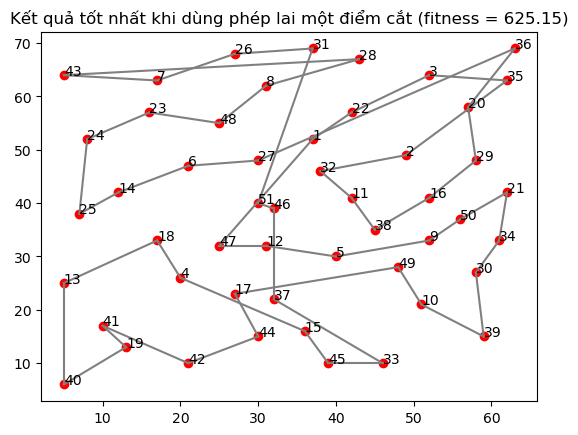

In [15]:
drawMap(cities, singlePoint_pop[0][1], f"Kết quả tốt nhất khi dùng phép lai một điểm cắt (fitness = {GA_with_singlePointCrossover[0][0]})")

In [16]:
GA_with_multiPointCrossover = []
minimum = 1e8
record_pop_multiPoint, record_fitness_multipoint = None, None
sum_fitness = np.zeros(500)
start = timeit.default_timer()

for i in range(30):
    random.seed(i)
    population = initPopulation(cities, size=100) # Khởi tạo quần thể đầu tiên
    pop, fitness = GA(population=population, crossover_func=multiPointCrossover, lenCities=len(cities))
    for j in range(500):
        sum_fitness[j] += fitness[j]
    if minimum > pop[0][0]:
        minimum = pop[0][0]
        record_pop_multiPoint, record_fitness_multipoint = pop, fitness
        
    GA_with_multiPointCrossover.append([round(pop[0][0], 2), "seed_" + str(i)])
    
average_fitness_2 = [float(x)/30 for x in sum_fitness]
multiPoint_time = round((timeit.default_timer() - start)/30, 2)

In [17]:
# Giá trị fitness tốt nhất trên từng random_seed
GA_with_multiPointCrossover = np.array(sorted(GA_with_multiPointCrossover))
pd.DataFrame(data=GA_with_multiPointCrossover[:,0], index=GA_with_multiPointCrossover[:,1], columns=['multiPointCrossover']).head()

,multiPointCrossover
seed_13,486.36
seed_9,488.18
seed_24,490.72
seed_3,499.7
seed_1,501.57


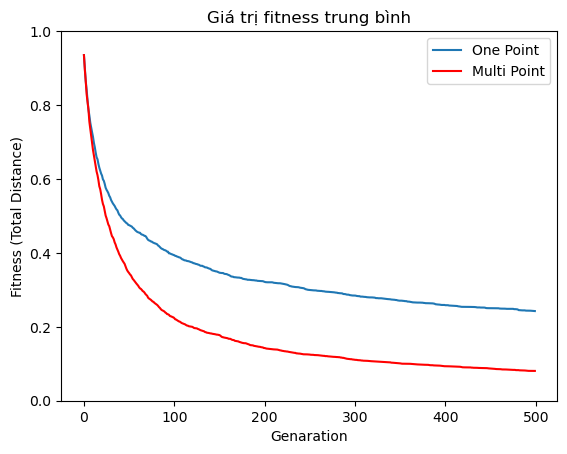

In [18]:
x=[i for i in range(500)]
plt.plot(x, scale(average_fitness_1), label="One Point")
plt.plot(x, scale(average_fitness_2), c="red", label="Multi Point")
plt.ylim([0,1])
plt.xlabel("Genaration")
plt.ylabel("Fitness (Total Distance)")
plt.title("Giá trị fitness trung bình")
plt.legend()
plt.show()

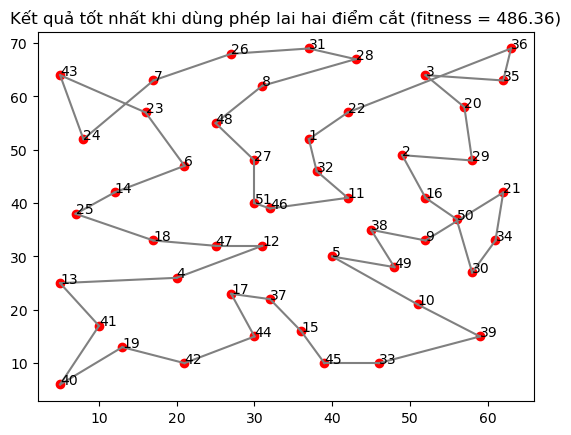

In [19]:
drawMap(cities, record_pop_multiPoint[0][1], f"Kết quả tốt nhất khi dùng phép lai hai điểm cắt (fitness = {GA_with_multiPointCrossover[0][0]})")

In [20]:
data = np.array([[GA_with_singlePointCrossover[0][0],
                 GA_with_multiPointCrossover[0][0]],
                 [siglePoint_time, multiPoint_time]])
pd.DataFrame(data=data, index=['best_fitness', 'time_taken(s)'], columns = ["single_points", "multi_points"])

,single_points,multi_points
best_fitness,625.15,486.36
time_taken(s),3.17,3.6
